#Resnet-50 Model


##Importing all the libraries


In [ ]:
import torch
from torchvision import transforms, datasets, models
from torch.utils.data import random_split, DataLoader
import torch.optim as optim
import torchvision
from torchvision.datasets import ImageFolder
import os
import matplotlib.pyplot as plt
import re
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import SubsetRandomSampler
from collections import Counter
import torch.nn.functional as F
from torch.optim import lr_scheduler
from PIL import Image
import torch.nn as nn
from torch.utils.data import WeightedRandomSampler
from scipy.ndimage import gaussian_filter, map_coordinates



##Mounting Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = "/content/drive/My Drive/Soil types/"

##Data Augmentation and Preprocessing

In [ ]:
transformation = transforms.Compose([
    transforms.Resize((224, 224)),
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation(10),
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor()
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


##Loading data from drive. Here I have used ImageFolder which assigns labels to different classes

In [ ]:
dataset = ImageFolder(root=data, transform=transformation)

In [ ]:
dataset

Dataset ImageFolder
    Number of datapoints: 156
    Root location: /content/drive/My Drive/Soil types/
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )

In [ ]:
class_to_idx = dataset.class_to_idx

In [ ]:
class_to_idx

{'Black Soil': 0,
 'Cinder Soil': 1,
 'Laterite Soil': 2,
 'Peat Soil': 3,
 'Yellow Soil': 4}

##Plotting the data distribution

<ipython-input-18-69872d2dd483>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(keys, rotation=45, ha='right')


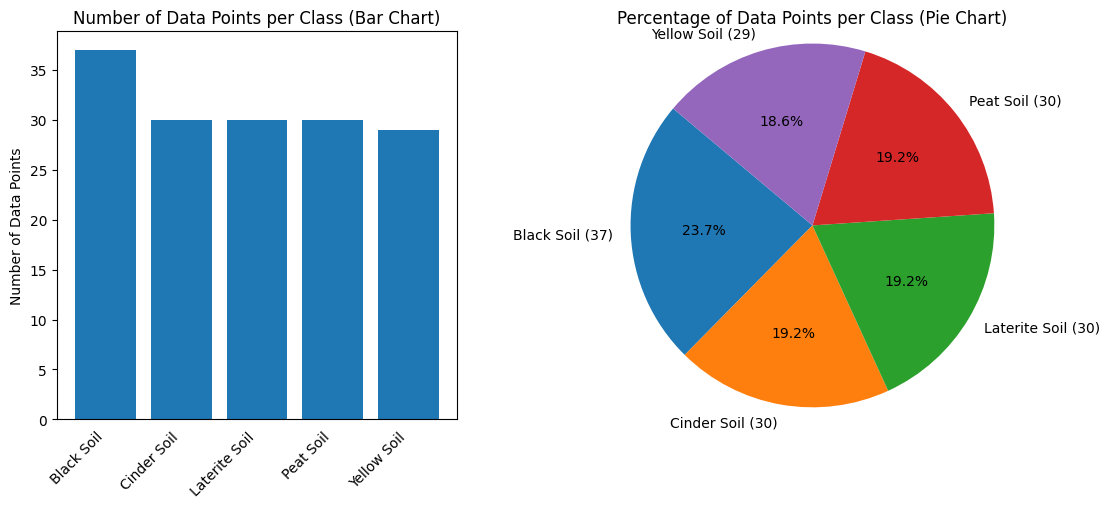

In [ ]:
mapped_values = [Counter(dataset.targets)[class_to_idx[key]] for key in class_to_idx]

keys = list(class_to_idx.keys())
labels = [f'{key} ({value})' for key, value in zip(keys, mapped_values)]


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.bar(keys, mapped_values)
ax1.set_ylabel('Number of Data Points')
ax1.set_title('Number of Data Points per Class (Bar Chart)')
ax1.set_xticklabels(keys, rotation=45, ha='right')
ax1.tick_params(axis='x', which='both', bottom=False)


ax2.pie(mapped_values, labels=labels, autopct='%1.1f%%', startangle=140)
ax2.set_title('Percentage of Data Points per Class (Pie Chart)')
ax2.axis('equal')


plt.tight_layout(pad=4.0)


plt.show()


##Loading images into a data loader

In [ ]:
batch_size = 10
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [ ]:
len(data_loader)

16

##Printing 5 images per class to make sure the labels and data augmentation is correct

Class Label: Black Soil, Class Index: 0


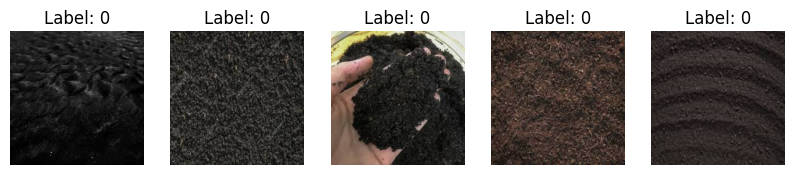

Class Label: Cinder Soil, Class Index: 1


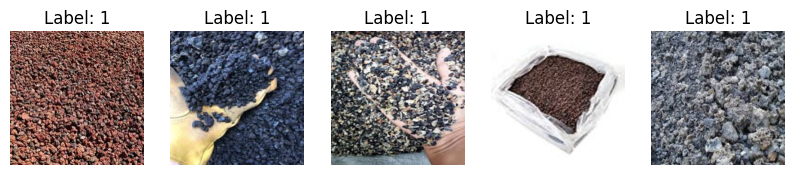

Class Label: Laterite Soil, Class Index: 2


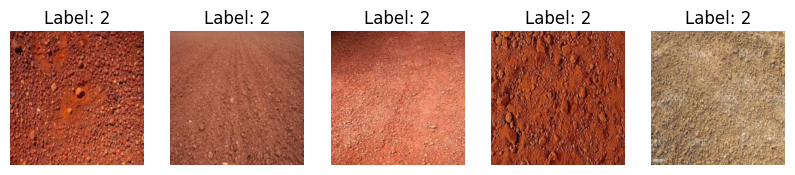

Class Label: Peat Soil, Class Index: 3


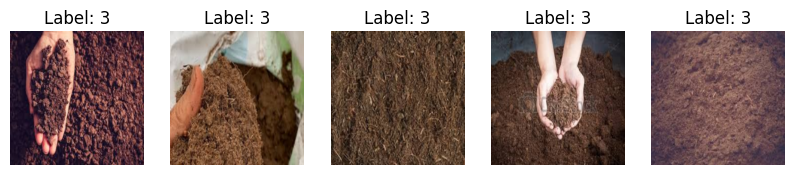

Class Label: Yellow Soil, Class Index: 4


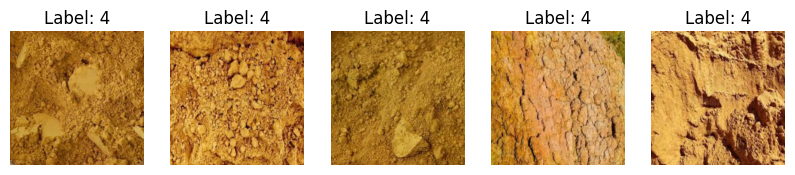

In [ ]:
num_images_per_class = 5
num_rows = 1
num_cols = 5

for class_label, class_index in class_to_idx.items():
    print(f"Class Label: {class_label}, Class Index: {class_index}")


    count_images = 0

    fig = plt.figure(figsize=(10, 10))

    for images, labels in data_loader:

        class_indices = (labels == class_index).nonzero(as_tuple=True)[0]

        for idx in class_indices:
            image = images[idx]
            label = labels[idx]

            image_np = image.permute(1, 2, 0).numpy()

            ax = fig.add_subplot(num_rows, num_cols, count_images+1)
            ax.imshow(image_np)
            ax.axis('off')  # Turn off axis labels
            ax.set_title(f"Label: {label}")

            count_images += 1
            if count_images >= num_images_per_class:
                break

        if count_images >= num_images_per_class:
            break

    plt.show()


##Splitting dataset into Training, Testing and Validation here we have used stratify parameter to balance data during split

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import SubsetRandomSampler, DataLoader


targets = np.array(dataset.targets)

train_idx, test_idx = train_test_split(np.arange(len(targets)), test_size=0.3, stratify=targets, random_state=42)

train_idx, val_idx = train_test_split(train_idx, test_size=0.15/0.85, stratify=targets[train_idx], random_state=42)

train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)
test_sampler = SubsetRandomSampler(test_idx)

train_loader = DataLoader(dataset, batch_size=10, sampler=train_sampler)
val_loader = DataLoader(dataset, batch_size=10, sampler=val_sampler)
test_loader = DataLoader(dataset, batch_size=10, sampler=test_sampler)


##This is the architecture of the Resnet-50 model used to train images.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=True)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 203MB/s]


## Freezing the parameters

In [ ]:
for param in model.parameters():
    param.requires_grad = False

##Modifying the last layer

In [ ]:
model.fc = nn.Sequential(nn.Linear(2048, 512),
                         nn.ReLU(),
                         nn.Dropout(0.2),
                         nn.Linear(512, 5),
                         nn.LogSoftmax(dim=1))

##Training the model with the few parameters initialised calculating validation and training loss along with the accuracy performed on the test dataset after each epoch

In [ ]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:

train_loss_list = []
val_loss_list = []
val_accuracy_list = []

min_val_loss = float('inf')

epochs = 35
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss = train_loss/len(train_loader)
    train_loss_list.append(train_loss)

    model.eval()
    with torch.no_grad():
        accuracy = 0
        val_loss = 0
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            logps = model.forward(inputs)
            loss = criterion(logps, labels)

            val_loss += loss.item()
            ps = torch.exp(logps)
            top_ps, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

        val_loss = val_loss/len(val_loader)
        val_loss_list.append(val_loss)
        accuracy = accuracy/len(val_loader)
        val_accuracy_list.append(accuracy)

    print(f"Epoch {epoch+1}/{epochs}.. "
          f"Train loss: {train_loss:.3f}.. "
          f"Val loss: {val_loss:.3f}.. "
          f"Val accuracy: {accuracy:.3f}")

    if val_loss < min_val_loss:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(min_val_loss, val_loss))
        torch.save(model.state_dict(), 'AUG.pth')
        min_val_loss = val_loss


Epoch 1/35.. Train loss: 1.744.. Val loss: 1.557.. Val accuracy: 0.250
Validation loss decreased (inf --> 1.556968).  Saving model ...
Epoch 2/35.. Train loss: 1.209.. Val loss: 1.217.. Val accuracy: 0.550
Validation loss decreased (1.556968 --> 1.217386).  Saving model ...
Epoch 3/35.. Train loss: 1.000.. Val loss: 1.048.. Val accuracy: 0.700
Validation loss decreased (1.217386 --> 1.048154).  Saving model ...
Epoch 4/35.. Train loss: 0.736.. Val loss: 0.909.. Val accuracy: 0.650
Validation loss decreased (1.048154 --> 0.909401).  Saving model ...
Epoch 5/35.. Train loss: 0.664.. Val loss: 0.909.. Val accuracy: 0.650
Validation loss decreased (0.909401 --> 0.908880).  Saving model ...
Epoch 6/35.. Train loss: 0.870.. Val loss: 1.032.. Val accuracy: 0.500
Epoch 7/35.. Train loss: 0.413.. Val loss: 0.866.. Val accuracy: 0.700
Validation loss decreased (0.908880 --> 0.865534).  Saving model ...
Epoch 8/35.. Train loss: 0.468.. Val loss: 0.882.. Val accuracy: 0.650
Epoch 9/35.. Train loss

In [ ]:
pip install matplotlib scikit-learn scikit-plot


##The following code shows the performance of this model on test dataset with the corresponding metrics

Classification Report:
               precision    recall  f1-score   support

   Black Soil       0.90      0.82      0.86        11
  Cinder Soil       0.80      0.89      0.84         9
Laterite Soil       0.80      0.44      0.57         9
    Peat Soil       1.00      0.67      0.80         9
  Yellow Soil       0.56      1.00      0.72         9

     accuracy                           0.77        47
    macro avg       0.81      0.76      0.76        47
 weighted avg       0.82      0.77      0.76        47


Confusion Matrix: 


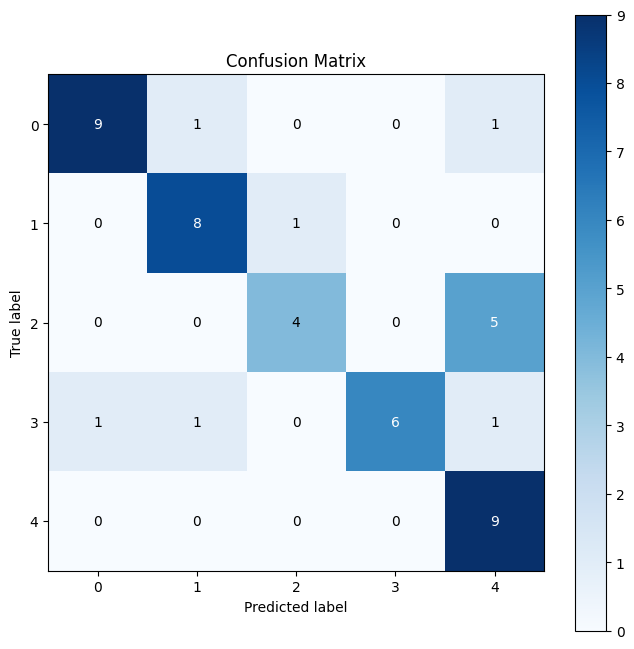

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import scikitplot as skplt

model.eval()
true_labels = []
pred_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        logps = model.forward(inputs)
        _, predicted = torch.max(logps.data, 1)
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(predicted.cpu().numpy())

print("Classification Report:")
print(classification_report(true_labels, pred_labels, target_names=dataset.classes))

print('\nConfusion Matrix: ')
skplt.metrics.plot_confusion_matrix(true_labels, pred_labels, figsize=(8,8))
plt.show()




In [ ]:
pip install gradio


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.3/20.3 MB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.3/66.3 kB 8.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.2/299.2 kB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.7/75.7 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 kB 9.4 MB/

In [ ]:
import gradio as gr

In [ ]:
def predict_image(img):

    knot_classes=['Black Soil','Cinder Soil','Laterite Soil','Peat Soil','Yellow Soil']

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        # transforms.RandomHorizontalFlip(),
        # transforms.RandomRotation(10),
        # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor()
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    image_tensor = transform(img).unsqueeze(0).cuda()

    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted = outputs.max(1)
        return knot_classes[predicted.item()]

input=gr.inputs.Image(type="pil", label="Upload Knot Image")
label=gr.outputs.Label(num_top_classes=2)

# Gradio interface
iface = gr.Interface(inputs=input,outputs=label,
    fn=predict_image,flag='hide'

)
iface.launch(debug='True')

<ipython-input-35-45f3ea3e8395>:21: GradioDeprecationWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  input=gr.inputs.Image(type="pil", label="Upload Knot Image")
<ipython-input-35-45f3ea3e8395>:21: GradioDeprecationWarning: `optional` parameter is deprecated, and it has no effect
  input=gr.inputs.Image(type="pil", label="Upload Knot Image")
<ipython-input-35-45f3ea3e8395>:22: GradioDeprecationWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  label=gr.outputs.Label(num_top_classes=2)
<ipython-input-35-45f3ea3e8395>:22: GradioUnusedKwargWarning: You have unused kwarg parameters in Label, please remove them: {'type': 'auto'}
  label=gr.outputs.Label(num_top_classes=2)
<ipython-input-35-45f3ea3e8395>:25: GradioUnusedKwargWarning: You have unused kwarg parameters in Interface, please remove them: {'flag':

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://84c20f7653cfd0ad27.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://84c20f7653cfd0ad27.gradio.live


##Hyperparameter Tuning

In [ ]:
!pip install optuna


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.2/404.2 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.3/225.3 kB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 11.0 MB/s eta 0:00:00


In [ ]:
import optuna
from torch.optim.lr_scheduler import ReduceLROnPlateau

def objective(trial):
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
    hidden_units = trial.suggest_int('hidden_units', 100, 500)
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.5)


    model = models.resnet50(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False

    model.fc = nn.Sequential(nn.Linear(2048, hidden_units),
                             nn.ReLU(),
                             nn.Dropout(dropout_rate),
                             nn.Linear(hidden_units, 11),
                             nn.LogSoftmax(dim=1))
    model.to(device)

    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.fc.parameters(), lr=lr)
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3, verbose=True)


    epochs = 10
    patience = 5
    best_val_loss = float('inf')
    counter = 0
    for epoch in range(epochs):
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            logps = model.forward(inputs)
            loss = criterion(logps, labels)
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            val_loss = 0
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                logps = model.forward(inputs)
                loss = criterion(logps, labels)
                val_loss += loss.item()

        avg_val_loss = val_loss/len(val_loader)
        scheduler.step(avg_val_loss)

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            counter = 0
        else:
            counter += 1
        if counter >= patience:
            print('Early stopping triggered.')
            break
=
    return best_val_loss

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

best_params = study.best_params
best_loss = study.best_value
print(f"Best parameters: {best_params}")
print(f"Best validation loss: {best_loss}")


[I 2023-08-07 19:06:16,250] A new study created in memory with name: no-name-e303973a-6bf2-4492-b80d-bff521a1114a
<ipython-input-60-332f64c47954>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
<ipython-input-60-332f64c47954>:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.5)
[I 2023-08-07 19:07:29,363] Trial 0 finished with value: 1.7194267213344574 and parameters: {'lr': 4.682385021173963e-05, 'hidden_units': 118, 'dropout_rate': 0.4494388340799361}. Best is trial 0 with value: 1.7194267213344574.
[I 2023-08-07 19:08:45,111] Trial 1 finished with value: 0.7865499630570412 and p

Epoch 00009: reducing learning rate of group 0 to 2.5361e-04.


[I 2023-08-07 19:30:10,172] Trial 18 finished with value: 0.7183485217392445 and parameters: {'lr': 0.002536080324267228, 'hidden_units': 338, 'dropout_rate': 0.1904319664840346}. Best is trial 18 with value: 0.7183485217392445.
[I 2023-08-07 19:31:25,825] Trial 19 finished with value: 0.8962385058403015 and parameters: {'lr': 0.00037318044548886946, 'hidden_units': 176, 'dropout_rate': 0.17815742542105228}. Best is trial 18 with value: 0.7183485217392445.
[I 2023-08-07 19:32:41,203] Trial 20 finished with value: 0.8111814484000206 and parameters: {'lr': 0.003015513014845423, 'hidden_units': 268, 'dropout_rate': 0.10537904019699906}. Best is trial 18 with value: 0.7183485217392445.
[I 2023-08-07 19:33:56,864] Trial 21 finished with value: 0.7293675132095814 and parameters: {'lr': 0.0014088168647055277, 'hidden_units': 333, 'dropout_rate': 0.18390467025048707}. Best is trial 18 with value: 0.7183485217392445.
[I 2023-08-07 19:35:12,410] Trial 22 finished with value: 0.7532819360494614 a

Epoch 00010: reducing learning rate of group 0 to 2.6561e-04.


[I 2023-08-07 20:02:56,667] Trial 44 finished with value: 0.7799565494060516 and parameters: {'lr': 0.0050347556733687125, 'hidden_units': 421, 'dropout_rate': 0.21914171743667119}. Best is trial 18 with value: 0.7183485217392445.
[I 2023-08-07 20:04:12,156] Trial 45 finished with value: 0.7614620253443718 and parameters: {'lr': 0.0013912242062423356, 'hidden_units': 342, 'dropout_rate': 0.39283312423663114}. Best is trial 18 with value: 0.7183485217392445.
[I 2023-08-07 20:05:27,981] Trial 46 finished with value: 0.7920080870389938 and parameters: {'lr': 0.000717891843482562, 'hidden_units': 497, 'dropout_rate': 0.4987560687683868}. Best is trial 18 with value: 0.7183485217392445.
[I 2023-08-07 20:06:43,669] Trial 47 finished with value: 0.786324217915535 and parameters: {'lr': 0.004054460424525662, 'hidden_units': 370, 'dropout_rate': 0.25231605563718784}. Best is trial 18 with value: 0.7183485217392445.
[I 2023-08-07 20:07:59,305] Trial 48 finished with value: 0.7742776498198509 and

Best parameters: {'lr': 0.002536080324267228, 'hidden_units': 338, 'dropout_rate': 0.1904319664840346}
Best validation loss: 0.7183485217392445
